In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, metrics, svm
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE

In [2]:
class Paths:
    kaggle_path = "kaggle_ECG_Arrythmia/"
    incart_2_lead_arrtyhmia_csv = "INCART 2-lead Arrhythmia Database.csv"
    mit_bih_arrtyhmia_csv = "MIT-BIH Arrhythmia Database.csv"
    mit_bih_supraventicular_arrtyhmia_csv = "MIT-BIH Supraventricular Arrhythmia Database.csv"
    sudden_cardiac_death_holder_csv = "Sudden Cardiac Death Holter Database.csv"
    incart_2_lead_arrtyhmia_path = kaggle_path + incart_2_lead_arrtyhmia_csv
    mit_bih_arrtyhmia_path = kaggle_path + mit_bih_arrtyhmia_csv
    mit_bih_supraventicular_arrtyhmia_path = kaggle_path + mit_bih_supraventicular_arrtyhmia_csv
    sudden_cardiac_death_holder_path = kaggle_path + sudden_cardiac_death_holder_csv

In [3]:
isPrintEnable :bool = False

def ConfusionMatrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def ValidScore(model, X, y):
    y_pred = model.predict(X)
    score = metrics.accuracy_score(y, y_pred)  
    print(score) 
    print("Accuracy:",metrics.accuracy_score(y, y_pred))
    # print("Precision:",metrics.precision_score(y, y_pred, average='binary', pos_label='arrhythmia'))
    print("*** Confusion Matrix ***")
    print(metrics.confusion_matrix(y, y_pred))
    ConfusionMatrix(y, y_pred)

def GetDf(path, ipe :bool = isPrintEnable):
    df = pd.read_csv(path) 
    if(ipe):
        print(df.shape)
        print(df.info())
        print(df.describe())
        df.head()
    return df

def GetBaseDataAndLabel(df :pd.DataFrame):
    data = df.iloc[:, 2:]
    label = df[['type']]
    return data, label

def SetBaseLabel(df :pd.DataFrame):
    df_res = df.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia')
    df_res = df_res.replace(['N'], 'normal')
    return df_res

def GetStandarizedData(train, test, ipe :bool = isPrintEnable):
    min_max_scaler = preprocessing.StandardScaler()
    X_train_scaled = min_max_scaler.fit_transform(train)
    X_test_scaled = min_max_scaler.transform(test)
    if (ipe):
        print(min_max_scaler.scale_)
    return X_train_scaled, X_test_scaled, min_max_scaler

In [4]:
for dirname, _, filenames in os.walk(Paths.kaggle_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle_ECG_Arrythmia/INCART 2-lead Arrhythmia Database.csv
kaggle_ECG_Arrythmia/MIT-BIH Arrhythmia Database.csv
kaggle_ECG_Arrythmia/MIT-BIH Supraventricular Arrhythmia Database.csv
kaggle_ECG_Arrythmia/Sudden Cardiac Death Holter Database.csv


In [7]:
def TrainAndValidRandomForest(path :str):
    df = GetDf(path)
    df = df.dropna()
    data, label = GetBaseDataAndLabel(df)
    label_binary = SetBaseLabel(label)
    X_train, X_test, y_train, y_test = train_test_split(data, label_binary, random_state=42, stratify=label_binary)
    X_train, X_test, _ = GetStandarizedData(X_train, X_test)
    model = RandomForestClassifier(random_state=101, n_estimators=150)
    model.fit(X_train, y_train)
    print('Accuracy for the train data', model.score(X_train, y_train))
    ValidScore(model, X_test, y_test)
    return model

def TrainAndValidSVM(path :str):
    df = GetDf(path)
    df = df.dropna()
    data, label = GetBaseDataAndLabel(df)
    # label = SetBaseLabel(label)
    X_train, X_test, y_train, y_test = train_test_split(data, label, random_state=42, stratify=label)
    X_train, X_test, _ = GetStandarizedData(X_train, X_test)
    model = svm.SVC(kernel="linear")
    model.fit(X_train, y_train)
    print('Accuracy for the train data', model.score(X_train, y_train))
    ValidScore(model, X_test, y_test)
    return model

def TrainAndValidSVMWithAdasyn(path :str, kernel :str = "linear"):
    df = GetDf(path)
    df = df.dropna()
    data, label = GetBaseDataAndLabel(df)
    # label = SetBaseLabel(label)
    X_train, X_test, y_train, y_test = train_test_split(data, label, random_state=42, stratify=label)
    X_train, X_test, _ = GetStandarizedData(X_train, X_test)
    adasyn = ADASYN(random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
    unique, counts = np.unique(y_train_resampled, return_counts=True)
    # Tworzenie słownika z wynikami
    class_counts = dict(zip(unique, counts))
    print("Liczba wystąpień każdej klasy:")
    for class_label, count in class_counts.items():
        print(f"{class_label}: {count}")
    model = svm.SVC(kernel=kernel)
    model.fit(X_train_resampled, y_train_resampled)
    print('Accuracy for the train data', model.score(X_train_resampled, y_train_resampled))
    ValidScore(model, X_test, y_test)
    return model


C:\Users\Cezary\AppData\Local\Temp\ipykernel_16976\358143073.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy for the train data 1.0
0.9971547583820818
Accuracy: 0.9971547583820818
*** Confusion Matrix ***
[[ 5462    84]
 [   41 38346]]


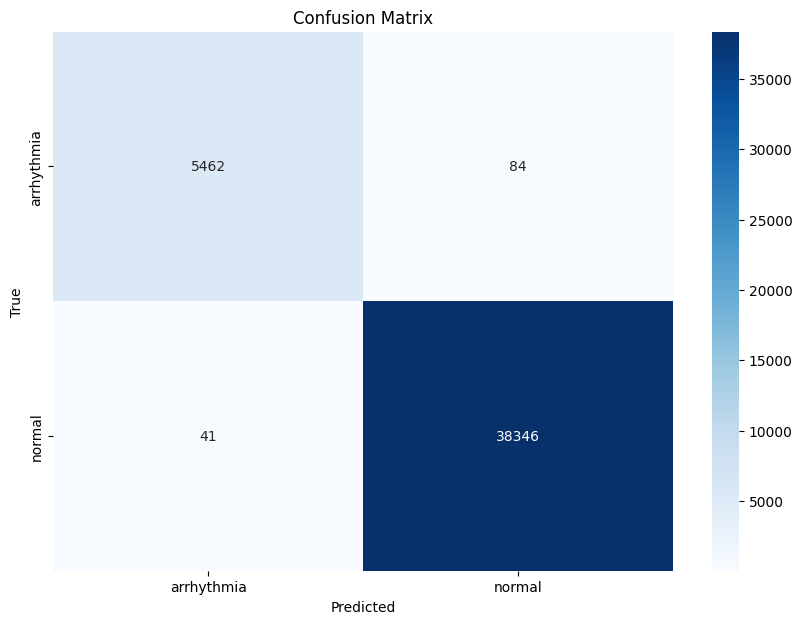

RandomForestClassifier(n_estimators=150, random_state=101)

In [6]:
TrainAndValidRandomForest(Paths.incart_2_lead_arrtyhmia_path)

C:\Users\Cezary\AppData\Local\Temp\ipykernel_16976\358143073.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy for the train data 1.0
0.9906248758590553
Accuracy: 0.9906248758590553
*** Confusion Matrix ***
[[ 2478   174]
 [   62 22459]]


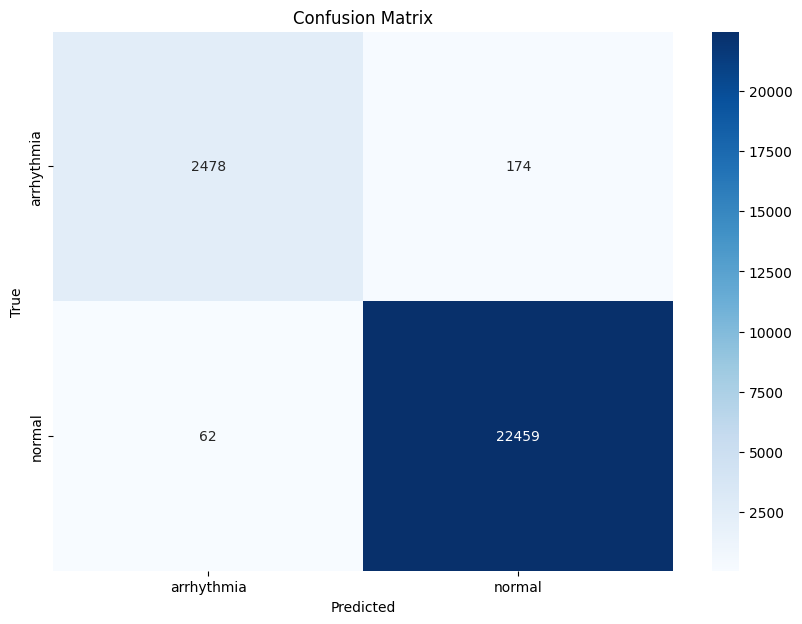

RandomForestClassifier(n_estimators=150, random_state=101)

In [7]:
TrainAndValidRandomForest(Paths.mit_bih_arrtyhmia_path)

C:\Users\Cezary\AppData\Local\Temp\ipykernel_16976\358143073.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy for the train data 1.0
0.9810007157264624
Accuracy: 0.9810007157264624
*** Confusion Matrix ***
[[ 4980   578]
 [  298 40251]]


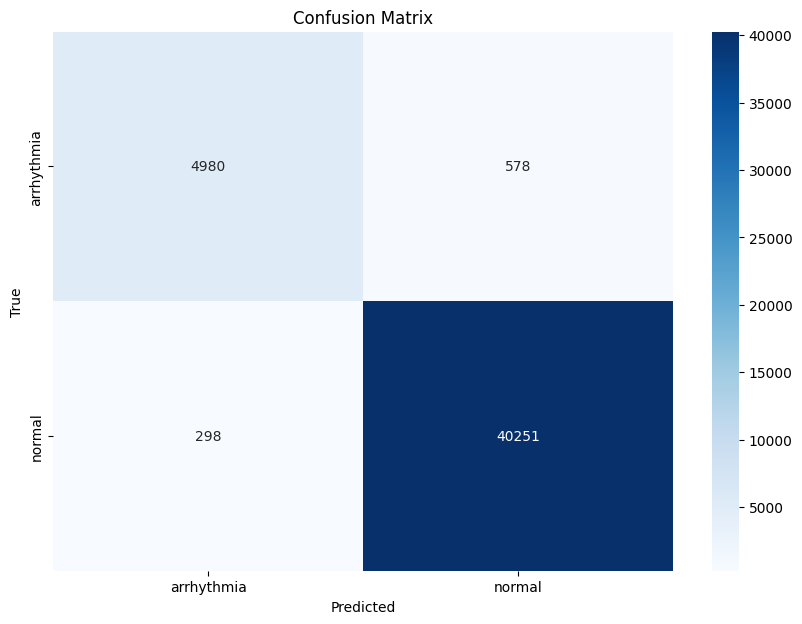

RandomForestClassifier(n_estimators=150, random_state=101)

In [8]:
TrainAndValidRandomForest(Paths.mit_bih_supraventicular_arrtyhmia_path)

C:\Users\Cezary\AppData\Local\Temp\ipykernel_16976\1057354264.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
C:\Users\Cezary\AppData\Local\Temp\ipykernel_16976\358143073.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy for the train data 1.0
0.9927453408261104
Accuracy: 0.9927453408261104
*** Confusion Matrix ***
[[ 2994   278]
 [  179 59543]]


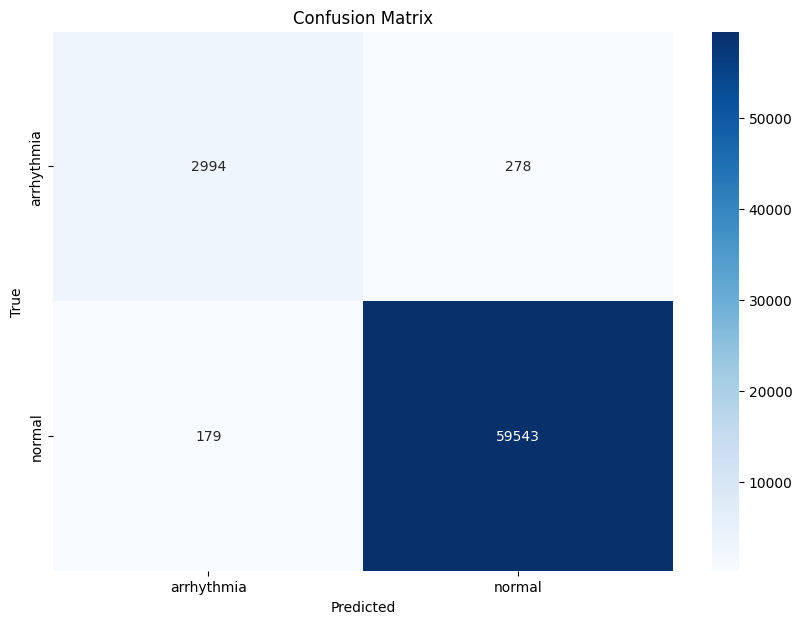

RandomForestClassifier(n_estimators=150, random_state=101)

In [9]:
TrainAndValidRandomForest(Paths.sudden_cardiac_death_holder_path)

c:\Users\Cezary\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for the train data 0.9888008740781208
0.9880499852047436
Accuracy: 0.9880499852047436
*** Confusion Matrix ***
[[    0    37     0     0    18]
 [    0 38273     1    18    95]
 [    0     1     0     0     0]
 [    0   106     0   361    23]
 [    0   204     0    22  4774]]


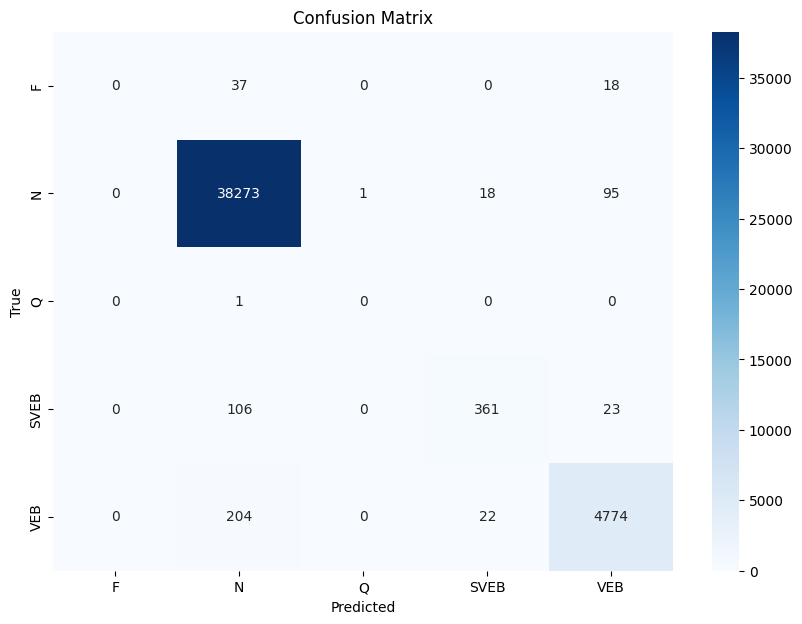

SVC(kernel='linear')

In [10]:
TrainAndValidSVM(Paths.incart_2_lead_arrtyhmia_path)

c:\Users\Cezary\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for the train data 0.9512023941946077
0.9494696698844
Accuracy: 0.9494696698844
*** Confusion Matrix ***
[[   52   141     0     0     8]
 [    2 22377     0     7   135]
 [    0     2     0     0     2]
 [    0   586     0    72    37]
 [    4   336     0    12  1400]]


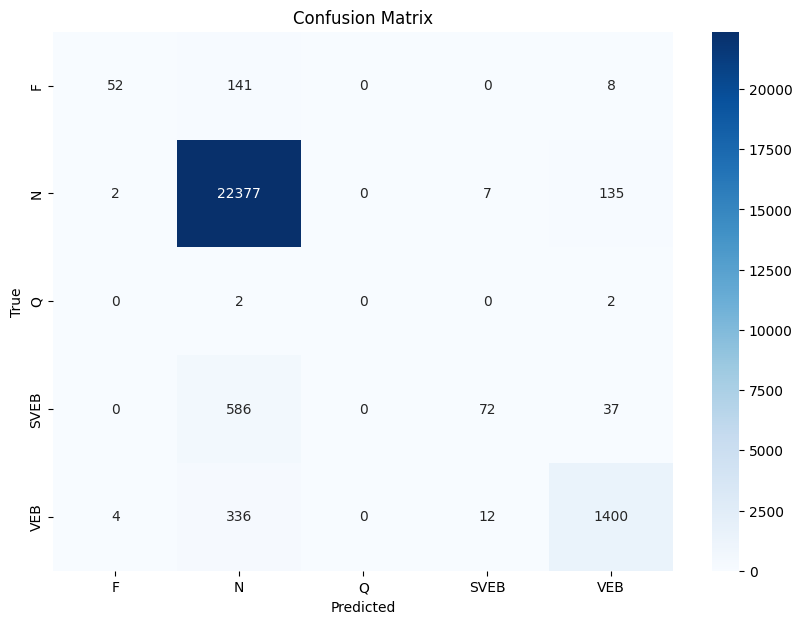

SVC(kernel='linear')

In [11]:
TrainAndValidSVM(Paths.mit_bih_arrtyhmia_path)

c:\Users\Cezary\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for the train data 0.930495007988664
0.9277983820244214
Accuracy: 0.9277983820244214
*** Confusion Matrix ***
[[    0     6     0     0     0]
 [    0 39930     0   453   166]
 [    0    14     0     2     4]
 [    0  1578     0  1332   138]
 [    0   710     0   258  1516]]


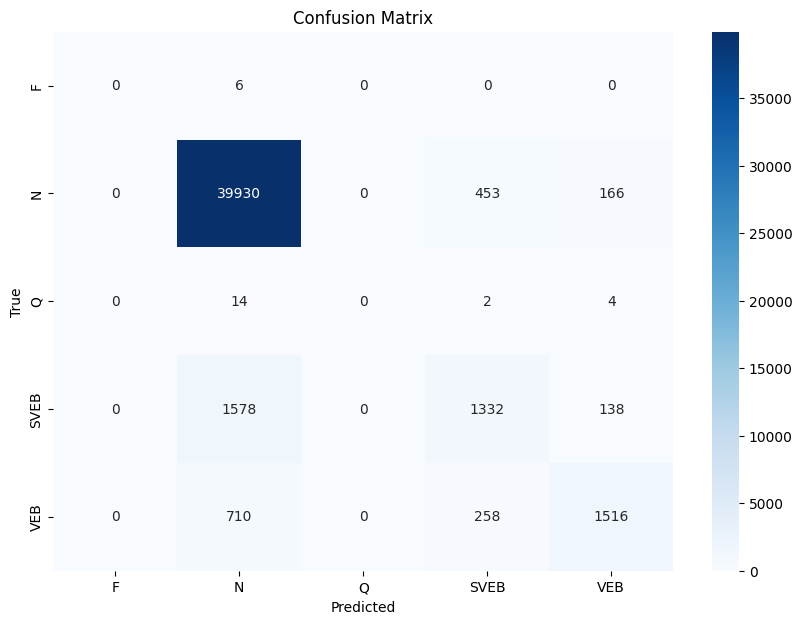

SVC(kernel='linear')

In [12]:
TrainAndValidSVM(Paths.mit_bih_supraventicular_arrtyhmia_path)

C:\Users\Cezary\AppData\Local\Temp\ipykernel_16976\1057354264.py:24: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
c:\Users\Cezary\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for the train data 0.9836174873797504
0.9832523732418961
Accuracy: 0.9832523732418961
*** Confusion Matrix ***
[[    0    49     0     0     3]
 [    0 59483     0     0   239]
 [    0     2     7     0     2]
 [    0   375     0     0    17]
 [    0   366     2     0  2449]]


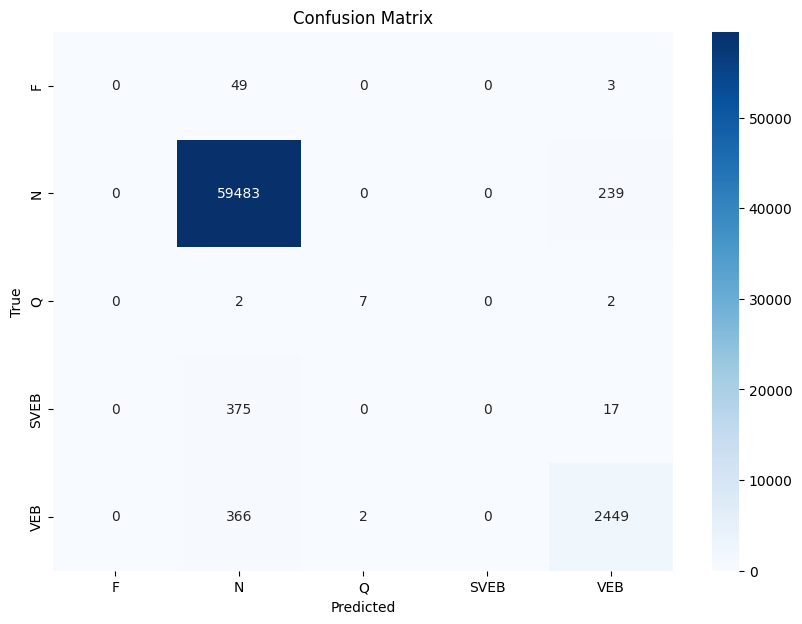

SVC(kernel='linear')

In [16]:
TrainAndValidSVM(Paths.sudden_cardiac_death_holder_path)

Liczba wystąpień każdej klasy:
F: 121646
N: 121646
Q: 121638
SVEB: 122052
VEB: 121653


c:\Users\Cezary\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for the train data 0.9613347901451609
0.9255427592339558
Accuracy: 0.9255427592339558
*** Confusion Matrix ***
[[    4     0     0     0     2]
 [   51 37573   106  2473   346]
 [    0     2     5     6     7]
 [    7    79     9  2728   225]
 [    1    43     2    74  2364]]


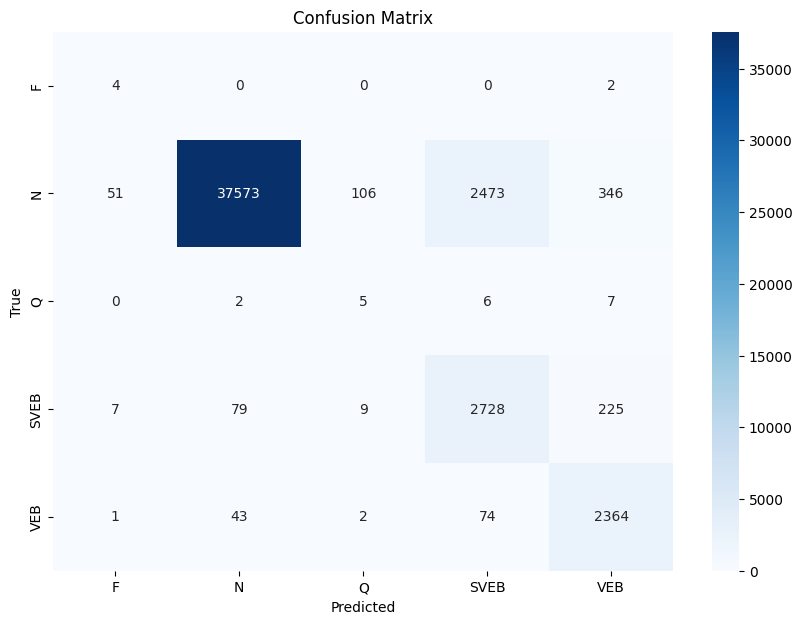

SVC()

In [8]:
TrainAndValidSVMWithAdasyn(Paths.mit_bih_supraventicular_arrtyhmia_path, "rbf")